In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
from time import time
from sklearn.metrics import roc_curve, auc, precision_recall_curve

Using TensorFlow backend.


In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename):     
    ds = pydicom.dcmread(filename)  
    if not ds.Modality=='DX':
        print('Load file {} ...'.format(filename))
        print("Modality is not DX")
    elif ds.PatientPosition not in ['AP','PA']:
        print('Load file {} ...'.format(filename))
        print("Patient position is not AP or PA")
    elif ds.BodyPartExamined != 'CHEST':
        print('Load file {} ...'.format(filename))
        print("Body part is not Chest")
    else:
        img = ds.pixel_array
        print('Load file : {}'.format(filename))
        plt.imshow(img)
        plt.show()
        return img
  
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_size): 
    # todo
    scaled_img=img/255.0 
    standardized_img=(scaled_img-np.mean(scaled_img))/np.std(scaled_img)
    resized_img = resize(standardized_img, (img_size[1], img_size[2]))
    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_path)
    print("Loaded model from disk")
    return loaded_model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo
    prediction_pro = model.predict(img)
    if prediction_pro>=thresh:
        prediction=1
    else:
        prediction=0
    return prediction

Loaded model from disk
Load file : test1.dcm


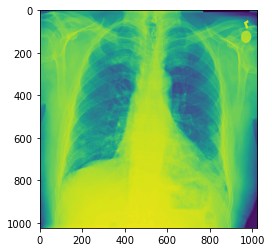

0
Load file : test2.dcm


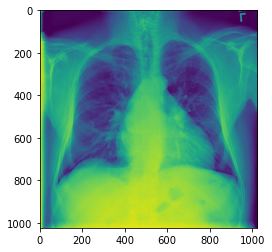

0
Load file : test3.dcm


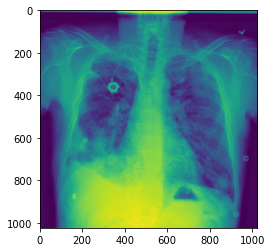

1
Load file test4.dcm ...
Body part is not Chest
Load file test5.dcm ...
Modality is not DX
Load file test6.dcm ...
Patient position is not AP or PA


In [3]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'#path to saved model
weight_path = 'xray_class_my_model.best.hdf5'#path to saved best weights

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16

my_model = load_model(model_path, weight_path)#loads model
thresh = 0.539#loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    img = np.array([])
    img = check_dicom(i)
    if img is None:
        continue  
    img_proc = preprocess_image(img,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)

In [4]:
pydicom.dcmread('test5.dcm').Modality

'CT'

In [5]:
pydicom.dcmread('test6.dcm').PatientPosition

'XX'